### Импорт библиотек

In [7]:
import sys

sys.path.extend(['../src/config', '../src/app/utils'])

import pandas as pd
import numpy as np
from tqdm import tqdm

from database_manager import PGSQL_Manager
from config import db_credentials

### 1. Загрузка данных из .csv

In [8]:
%%time

# Список .csv файлов для загрузки
csv_list = ['application_train.csv', 'application_test.csv', 'application_train_test.csv',
            'bureau_balance.csv', 'bureau.csv', 'credit_card_balance.csv',
            'installments_payments.csv', 'pos_cash_balance.csv', 'previous_application.csv']

# Загрузим данные из .csv файлов в словарь датафреймов
df_dict = {csv.replace('.csv', ''): pd.read_csv(csv) for csv in csv_list}

# Приведем названия столбцов к нижнему регистру
for dataframe in df_dict.keys():
    df_dict[dataframe].columns = df_dict[dataframe].columns.str.lower()

CPU times: total: 14 s
Wall time: 40.9 s


### 2. Проверим на валидность схему базы данных

Проверим <u>Primary</u> и <u>Foreign</u> ключи обозначенные в схеме данных:
- **Primary Key:** В столбце должны быть только уникальные значения и отсутствовать пропуски.
- **Foreign Key:** Столбец данных должен быть подмножеством стобца Primary Key из другой таблицы.

#### 2.1 Primary Keys

In [9]:
# Найдем столбцы без пропусков и с уникальными значениями
for df_name, dataframe in df_dict.items():
    for col in dataframe.columns:
        if dataframe[col].is_unique:
            print(df_name, col, dataframe[col].is_unique)

application_train sk_id_curr True
application_test sk_id_curr True
application_train_test sk_id_curr True
bureau sk_id_bureau True
previous_application sk_id_prev True


Результат совпадает с ожидаемым на основании схемы данных.  
Таблицы test и train не будем записывать в базу, так как они являются частями train_test таблицы.  
После записи таблицы в базу, назначим найденные столбцы как Primary Key.

In [10]:
primary_key_mappings = {"application_train_test": "sk_id_curr",
                        "bureau": "sk_id_bureau",
                        "previous_application": "sk_id_prev"
}

#### 2.2 Foreign Keys
В ходе предвательного знакомства с данными было обнаружено, что указанные в схеме сочетания Primary: Foregn Key, не всегда валидны.

- Поскольку тема домашнего задания это **SQL** и задачей является загрузка таблиц в **RDB**, а в сутках время ограничено, то в случае возникновения расхождений, - мы будем их устранять без страха и упрёка.

In [11]:
foreign_key_mappings = {}

##### 2.2.1 bureau_balance & bureau
Схемой подразумевается связь по столбцу `sk_id_bureau`

In [12]:
print(f"bureau_balance.sk_id_bureau подмножество bureau.sk_id_bureau:\
     {set(df_dict['bureau_balance'].sk_id_bureau).issubset(set(df_dict['bureau'].sk_id_bureau))}")

bureau_balance.sk_id_bureau подмножество bureau.sk_id_bureau:     False


In [13]:
difference = set(df_dict['bureau_balance'].sk_id_bureau) - set(df_dict['bureau'].sk_id_bureau)
df_dict['bureau_balance'] = df_dict['bureau_balance'][~df_dict['bureau_balance'].sk_id_bureau.isin(difference)]

print(f"bureau_balance.sk_id_bureau подмножество bureau.sk_id_bureau:\
     {set(df_dict['bureau_balance'].sk_id_bureau).issubset(set(df_dict['bureau'].sk_id_bureau))}")

bureau_balance.sk_id_bureau подмножество bureau.sk_id_bureau:     True


In [14]:
foreign_key_mappings["bureau_balance"] = ["bureau", "sk_id_bureau"]

##### 2.2.2 bureau & application_train_test
Схемой подразумевается связь по столбцу `sk_id_curr`

In [15]:
print(f"bureau.sk_id_curr подмножество application_train_test.sk_curr:\
     {set(df_dict['bureau'].sk_id_curr).issubset(set(df_dict['application_train_test'].sk_id_curr))}")

bureau.sk_id_curr подмножество application_train_test.sk_curr:     True


In [16]:
foreign_key_mappings["bureau"] = ["application_train_test", "sk_id_curr"]

##### 2.2.3 previous_application & application_train_test
Схемой подразумевается связь по столбцу `sk_id_curr`

In [17]:
print(f"previous_application.sk_id_curr подмножество application_train_test.sk_curr:\
     {set(df_dict['previous_application'].sk_id_curr).issubset(set(df_dict['application_train_test'].sk_id_curr))}")

previous_application.sk_id_curr подмножество application_train_test.sk_curr:     True


In [18]:
foreign_key_mappings["previous_application"] = ["application_train_test", "sk_id_curr"]

##### 2.2.4 credit_card_balance & application_train_test
Схемой подразумевается связь по столбцу `sk_id_curr`

In [19]:
print(f"credit_card_balance.sk_id_curr подмножество application_train_test.sk_curr:\
     {set(df_dict['credit_card_balance'].sk_id_curr).issubset(set(df_dict['application_train_test'].sk_id_curr))}")

credit_card_balance.sk_id_curr подмножество application_train_test.sk_curr:     True


In [20]:
foreign_key_mappings["credit_card_balance"] = ["application_train_test", "sk_id_curr"]

##### 2.2.5 installments_payments & application_train_test
Схемой подразумевается связь по столбцу `sk_id_curr`

In [21]:
print(f"installments_payments.sk_id_prev подмножество application_train_test.sk_id_curr:\
     {set(df_dict['installments_payments'].sk_id_curr).issubset(set(df_dict['application_train_test'].sk_id_curr))}")

installments_payments.sk_id_prev подмножество application_train_test.sk_id_curr:     True


In [22]:
foreign_key_mappings["installments_payments"] = ["application_train_test", "sk_id_curr"]

##### 2.2.6 pos_cash_balance & application_train_test
Схемой подразумевается связь по столбцу `sk_id_curr`

In [23]:
print(f"pos_cash_balance.sk_id_prev подмножество application_train_test.sk_id_curr:\
     {set(df_dict['pos_cash_balance'].sk_id_curr).issubset(set(df_dict['application_train_test'].sk_id_curr))}")

pos_cash_balance.sk_id_prev подмножество application_train_test.sk_id_curr:     True


In [24]:
foreign_key_mappings["pos_cash_balance"] = ["application_train_test", "sk_id_curr"]

### 3. Оптимизируем типы данных перед записью в базу данных

In [26]:
%%time
# Инициализруем класс для манипуляций с базой данных
pgsql_manager = PGSQL_Manager()

# Словарь для хранения типов данных столбцов,
# где: key (название датафрейма): value (словарь типов данных)
df_dtypes = {}

# Воспользуемся методом evaluate_pandas_dtypes(), класса pgsql_manager
for df_name, dataframe in df_dict.items():
    df_dtypes[df_name] = pgsql_manager.evaluate_pandas_dtypes(dataframe)

CPU times: total: 10.9 s
Wall time: 24.7 s


### 4. Запишем таблицы в базу данных PostgreSQL
**application_train** и **application_test** не будем записывать в базу.

In [27]:
for df in ['application_train', 'application_test']:
    del df_dict[df]
    del df_dtypes[df]

In [28]:
# Запишем данные для доступа к базе данных в словарь
DB_ARGS = db_credentials(user_type="admin")

# Установим "master" соединение с базой данных
engine = pgsql_manager.connect(**DB_ARGS)

Соединение установлено


In [ ]:
%%time
# Запишем датафреймы в базу данных
for df_name, dataframe in tqdm(df_dict.items()):

    dtypes = df_dtypes[df_name]
    dataframe.to_sql(df_name, engine, if_exists='replace', index=False, dtype=dtypes)

### 5. Назначим Primary Keys

In [29]:
primary_key_mappings

{'application_train_test': 'sk_id_curr',
 'bureau': 'sk_id_bureau',
 'previous_application': 'sk_id_prev'}

In [ ]:
for table, primary_key in primary_key_mappings.items():
    query = f"ALTER TABLE {table} ADD PRIMARY KEY ({primary_key});"
    pgsql_manager.send_sql_query(query)

### 6. Назначим Foreign Keys

In [30]:
foreign_key_mappings

{'bureau_balance': ['bureau', 'sk_id_bureau'],
 'bureau': ['application_train_test', 'sk_id_curr'],
 'previous_application': ['application_train_test', 'sk_id_curr'],
 'credit_card_balance': ['application_train_test', 'sk_id_curr'],
 'installments_payments': ['application_train_test', 'sk_id_curr'],
 'pos_cash_balance': ['application_train_test', 'sk_id_curr']}

In [ ]:
for table, reference in foreign_key_mappings.items():
    query = f"""ALTER TABLE {table} ADD CONSTRAINT {table}_fkey FOREIGN KEY ({reference[1]}) REFERENCES {reference[0]} ({reference[1]})"""
    pgsql_manager.send_sql_query(query)

### 7. Создадим Индексы
Создадим B-Tree индексы на основе Foreign Key для всех таблиц, у которых отсутствует Primary Key.

In [ ]:
# Таблица bureau_balance
query = """CREATE INDEX idx_sk_id_bureau ON bureau_balance (sk_id_bureau);"""
pgsql_manager.send_sql_query(query)

In [ ]:
# Таблица pos_cash_balance
query = """CREATE INDEX idx_sk_id_curr ON pos_cash_balance (sk_id_curr);"""
pgsql_manager.send_sql_query(query)

In [ ]:
# Таблица installments_payments
query = """CREATE INDEX installments_payments_idx_sk_id_curr ON installments_payments (sk_id_curr);"""
pgsql_manager.send_sql_query(query)

In [ ]:
# Таблица credit_card_balance_csv
query = """CREATE INDEX credit_card_balance_idx_sk_id_curr ON credit_card_balance (sk_id_curr);"""
pgsql_manager.send_sql_query(query)

### 8. Простые запросы

In [31]:
pgsql_guest = PGSQL_Manager()

DB_ARGS = db_credentials(user_type="guest")

# Установим гостевое соединение с базой данных
engine = pgsql_guest.connect(**DB_ARGS)

Соединение установлено


#### 8.1 Запрос из "bureau"

In [32]:
%%time

query = """
SELECT *
FROM bureau;
"""
pgsql_guest.get_df_from_query(query)

CPU times: total: 4.33 s
Wall time: 2min 52s


,sk_id_curr,sk_id_bureau,credit_active,credit_currency,days_credit,credit_day_overdue,days_credit_enddate,days_enddate_fact,amt_credit_max_overdue,cnt_credit_prolong,amt_credit_sum,amt_credit_sum_debt,amt_credit_sum_limit,amt_credit_sum_overdue,credit_type,days_credit_update,amt_annuity
0,200373,6026371,Active,currency 1,-466,0,1360.0,NaN,NaN,0,236844.0,199534.5,0.0,0.0,Consumer credit,-34,5103.0
1,200373,6026372,Active,currency 1,-381,0,1445.0,NaN,NaN,0,247500.0,214362.0,0.0,0.0,Consumer credit,-14,6354.0
2,269222,6026373,Active,currency 1,-1428,0,-879.0,NaN,NaN,0,209209.5,101349.0,NaN,0.0,Consumer credit,-539,NaN
3,269222,6026377,Closed,currency 1,-1903,0,-1537.0,-1534.0,NaN,0,116311.5,0.0,0.0,0.0,Consumer credit,-980,0.0
4,269222,6026378,Active,currency 1,-372,0,-73.0,NaN,NaN,0,135000.0,129217.5,0.0,0.0,Credit card,-141,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716423,200373,6026365,Closed,currency 1,-750,0,-20.0,-659.0,NaN,0,67500.0,0.0,0.0,0.0,Consumer credit,-644,63976.5
1716424,200373,6026367,Closed,currency 1,-830,0,-465.0,-680.0,NaN,0,121500.0,0.0,0.0,0.0,Consumer credit,-671,83713.5
1716425,200373,6026368,Closed,currency 1,-1042,0,-677.0,-915.0,NaN,0,117000.0,0.0,0.0,0.0,Consumer credit,-797,10935.0
1716426,200373,6026369,Active,currency 1,-648,0,83.0,NaN,NaN,0,67977.0,12109.5,0.0,0.0,Consumer credit,-28,3078.0


In [33]:
%%time

query = """
SELECT sk_id_curr,
       sk_id_bureau,
       credit_active,
       credit_currency
FROM bureau;
"""
pgsql_guest.get_df_from_query(query)

CPU times: total: 2.09 s
Wall time: 54 s


,sk_id_curr,sk_id_bureau,credit_active,credit_currency
0,200373,6026371,Active,currency 1
1,200373,6026372,Active,currency 1
2,269222,6026373,Active,currency 1
3,269222,6026377,Closed,currency 1
4,269222,6026378,Active,currency 1
...,...,...,...,...
1716423,200373,6026365,Closed,currency 1
1716424,200373,6026367,Closed,currency 1
1716425,200373,6026368,Closed,currency 1
1716426,200373,6026369,Active,currency 1


#### 8.2 Простой group by

In [34]:
%%time

query = """
SELECT sk_id_curr AS id_loan,
       COUNT(sk_id_bureau) AS count_loans_bki_history,
       SUM(amt_credit_sum) AS loans_sum
FROM bureau
GROUP BY sk_id_curr
LIMIT 10;
"""
pgsql_guest.get_df_from_query(query)

CPU times: total: 0 ns
Wall time: 1.93 s


,id_loan,count_loans_bki_history,loans_sum
0,100001,7,1453365.00
1,100002,8,865055.56
2,100003,4,1017400.50
3,100004,2,189037.80
4,100005,3,657126.00
5,100007,1,146250.00
6,100008,3,468445.50
7,100009,18,4800811.50
8,100010,2,990000.00
9,100011,4,435228.30


#### 8.3 Пример join

In [35]:
%%time

query = """
SELECT *
FROM application_train_test
JOIN bureau ON application_train_test.sk_id_curr = bureau.sk_id_curr;
"""
pgsql_guest.get_df_from_query(query)

CPU times: total: 30.3 s
Wall time: 11min 51s


,sk_id_curr,target,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,...,days_enddate_fact,amt_credit_max_overdue,cnt_credit_prolong,amt_credit_sum,amt_credit_sum_debt,amt_credit_sum_limit,amt_credit_sum_overdue,credit_type,days_credit_update,amt_annuity
0,132061,None,Cash loans,F,False,True,0,121500.0,278460.0,21676.5,...,-1293.0,NaN,0,148005.00,0.0,0.0,0.0,Consumer credit,-112,29817.0
1,132061,None,Cash loans,F,False,True,0,121500.0,278460.0,21676.5,...,-764.0,NaN,0,44775.00,0.0,0.0,0.0,Consumer credit,-763,0.0
2,132061,None,Cash loans,F,False,True,0,121500.0,278460.0,21676.5,...,-1335.0,NaN,0,0.00,0.0,0.0,0.0,Credit card,-1279,NaN
3,132061,None,Cash loans,F,False,True,0,121500.0,278460.0,21676.5,...,-449.0,0.0,0,58099.50,0.0,0.0,0.0,Consumer credit,-447,NaN
4,339662,False,Cash loans,M,True,False,0,315000.0,1701229.5,49743.0,...,-2311.0,NaN,0,180000.00,NaN,NaN,0.0,Credit card,-2311,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716423,259223,None,Cash loans,F,True,True,0,391500.0,509400.0,28444.5,...,NaN,NaN,0,895500.00,766264.5,0.0,0.0,Consumer credit,-8,34200.0
1716424,322614,None,Cash loans,F,False,True,2,135000.0,440784.0,34956.0,...,-179.0,0.0,0,29641.50,0.0,0.0,0.0,Consumer credit,-177,NaN
1716425,232110,None,Cash loans,F,False,True,1,90000.0,958122.0,34542.0,...,-1425.0,NaN,0,36501.84,0.0,NaN,0.0,Consumer credit,-879,NaN
1716426,232110,None,Cash loans,F,False,True,1,90000.0,958122.0,34542.0,...,-112.0,0.0,0,148050.00,0.0,0.0,0.0,Consumer credit,-110,NaN


In [36]:
%%time

query = """
SELECT application_train_test.sk_id_curr, 
    code_gender, 
    sk_id_bureau, 
    amt_credit_sum
FROM application_train_test
JOIN bureau ON application_train_test.sk_id_curr = bureau.sk_id_curr;
"""
pgsql_guest.get_df_from_query(query)

CPU times: total: 1.39 s
Wall time: 39.9 s


,sk_id_curr,code_gender,sk_id_bureau,amt_credit_sum
0,269222,F,6026373,209209.5
1,269222,F,6026377,116311.5
2,269222,F,6026378,135000.0
3,269222,F,6026379,630000.0
4,269222,F,6026381,116311.5
...,...,...,...,...
1716423,200373,F,6026365,67500.0
1716424,200373,F,6026367,121500.0
1716425,200373,F,6026368,117000.0
1716426,200373,F,6026369,67977.0


In [37]:
%%time

query = """
SELECT sk_id_curr, 
       id_loan, 
       code_gender, 
       count_loans_bki_history, 
       loans_sum
FROM application_train_test
JOIN
    (SELECT sk_id_curr AS id_loan, 
    COUNT(sk_id_bureau) AS count_loans_bki_history, 
    SUM(amt_credit_sum) AS loans_sum
FROM bureau
GROUP BY sk_id_curr) bureau_new
ON application_train_test.sk_id_curr = bureau_new.id_loan;
"""
pgsql_guest.get_df_from_query(query)

CPU times: total: 391 ms
Wall time: 16.8 s


,sk_id_curr,id_loan,code_gender,count_loans_bki_history,loans_sum
0,100007,100007,M,1,146250.0
1,100014,100014,F,8,2729932.5
2,100031,100031,F,7,3970651.5
3,100033,100033,M,1,675000.0
4,100059,100059,M,5,2157469.2
...,...,...,...,...,...
305806,456237,456237,F,1,98145.0
305807,456238,456238,M,6,1109502.0
305808,456239,456239,M,11,6262312.5
305809,456241,456241,F,5,1215000.0


### 9. Упражнения

In [38]:
%%time

# вывести средний доход среди всех клиентов
query="""
SELECT AVG(amt_income_total) AS average_income
FROM application_train_test;
"""
pgsql_guest.get_df_from_query(query)

CPU times: total: 0 ns
Wall time: 1.04 s


,average_income
0,170116.05986


Нужно исправить значения в поле days_birth.

In [42]:
query= """UPDATE application_train_test
          SET days_birth = days_birth * -1;"""

pgsql_manager.send_sql_query(query)

In [43]:
%%time

# вывести минимальный и максимальный возраст среди всех клиентов
query="""
SELECT (MIN(days_birth) / 365) AS min_age,
       (MAX(days_birth) / 365) AS max_age
FROM application_train_test;
"""
pgsql_guest.get_df_from_query(query)

CPU times: total: 0 ns
Wall time: 1.02 s


,min_age,max_age
0,20,69


In [44]:
%%time

# вывести количество мужчин и женщин
query="""
SELECT code_gender, COUNT(*) as count
FROM application_train_test
GROUP BY code_gender;
"""
pgsql_guest.get_df_from_query(query)

CPU times: total: 0 ns
Wall time: 1.03 s


,code_gender,count
0,F,235126
1,M,121125
2,XNA,4


In [45]:
%%time

# вывести общую сумму, количество и среднюю сумму, запрошенную клиентами в кредит с авто и без
query = """
SELECT flag_own_car, sum(amt_credit), count(amt_credit), avg(amt_credit)
FROM application_train_test
GROUP BY flag_own_car
"""
pgsql_guest.get_df_from_query(query)

CPU times: total: 0 ns
Wall time: 1.05 s


,flag_own_car,sum,count,avg
0,False,1.303935e+11,235235,554317.381867
1,True,7.900402e+10,121020,652786.569683


In [46]:
%%time

# вывести доли клиентов с различным образованием
query = """
SELECT name_education_type AS education_type, 
       CAST(education_count AS REAL) / total_count AS rate
       
FROM (
      SELECT name_education_type, 
             COUNT(sk_id_curr) AS education_count
      FROM application_train_test
      GROUP BY name_education_type
      ) AS alias_1
      
CROSS JOIN (
            SELECT COUNT(sk_id_curr) AS total_count
            FROM application_train_test
            ) AS alias_2
            
ORDER BY rate DESC;
"""

pgsql_guest.get_df_from_query(query)

CPU times: total: 0 ns
Wall time: 1.09 s


,education_type,rate
0,Secondary / secondary special,0.708422
1,Higher education,0.245271
2,Incomplete higher,0.033687
3,Lower secondary,0.012045
4,Academic degree,0.000575


In [ ]:
# Здесь булевы значения (0, 1) в виде строк. К такому я не был готов. Исправлю тип данных в базе.

for column in ['flag_own_car', 'flag_own_realty']:
    pgsql_manager.send_sql_query(f"""ALTER TABLE application_train_test 
                                     ALTER COLUMN {column} TYPE boolean 
                                     USING (CASE WHEN {column} = '1' THEN True ELSE False END);""")

Исходим из предположения, что чтобы получить количество *полных* лет нужно округлить значение в меньшую сторону.

In [47]:
%%time

# подсчитать количество полных лет для клиентов, у которых есть во владении автомобиль и недвижимость.
# вывести топ 10 по возрастанию
query = """
SELECT FLOOR(days_birth / 365) as full_years_age
FROM application_train_test
WHERE flag_own_car is True 
    AND flag_own_realty is True
ORDER BY full_years_age ASC
LIMIT 10;
"""

pgsql_guest.get_df_from_query(query)

CPU times: total: 0 ns
Wall time: 1.03 s


,full_years_age
0,20.0
1,20.0
2,21.0
3,21.0
4,21.0
5,21.0
6,21.0
7,21.0
8,21.0
9,21.0


В таблице у каждого клиента есть минимум 1 член семьи (он сам). Таким образом, не будет деления на ноль.

In [48]:
%%time

# вывести тех клиентов, у кого доход на одного члена семьи в два раза больше, чем в среднем на одного члена семьи по выборке
query = """
WITH cte AS (SELECT AVG(amt_income_total / cnt_fam_members) AS avg_inc_per_family_member
             FROM application_train_test)

SELECT *
FROM application_train_test
WHERE (
       (amt_income_total / cnt_fam_members) /
       (SELECT avg_inc_per_family_member FROM cte)
      ) >= 2;
"""
pgsql_guest.get_df_from_query(query)

CPU times: total: 266 ms
Wall time: 16.3 s


,sk_id_curr,target,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,...,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year
0,197941,False,Cash loans,M,False,True,0,202500.0,582768.0,31176.0,...,False,False,False,False,0.0,0.0,0.0,0.0,1.0,5.0
1,199807,True,Cash loans,M,True,False,0,225000.0,270000.0,21775.5,...,False,False,False,False,0.0,0.0,0.0,0.0,1.0,0.0
2,200305,False,Cash loans,F,True,True,0,247500.0,1288350.0,37800.0,...,False,False,False,False,0.0,0.0,0.0,0.0,1.0,0.0
3,202274,False,Cash loans,F,False,True,0,225000.0,183784.5,14350.5,...,False,False,False,False,0.0,0.0,0.0,0.0,1.0,1.0
4,203498,False,Cash loans,M,True,True,0,450000.0,701730.0,71905.5,...,False,False,False,False,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27728,184056,None,Cash loans,F,True,True,0,270000.0,225000.0,13765.5,...,False,False,False,False,0.0,0.0,0.0,0.0,0.0,6.0
27729,186403,False,Cash loans,F,False,True,0,202500.0,508495.5,26091.0,...,False,False,False,False,0.0,0.0,0.0,0.0,0.0,2.0
27730,188685,False,Cash loans,F,False,True,0,202500.0,1185120.0,42696.0,...,False,False,False,False,0.0,0.0,0.0,2.0,0.0,0.0
27731,189739,False,Cash loans,F,True,True,0,675000.0,473760.0,50400.0,...,False,False,False,False,0.0,0.0,0.0,0.0,0.0,1.0


In [49]:
%%time

# вывести клиентов старше 60 лет по которым нет данных в bureau
query = """
SELECT *
FROM application_train_test AS main
WHERE (main.days_birth / 365) > 60
AND NOT EXISTS (
    SELECT 1
    FROM bureau AS sub
    WHERE main.sk_id_curr = sub.sk_id_curr
);
"""
pgsql_guest.get_df_from_query(query)

CPU times: total: 15.6 ms
Wall time: 4.16 s


,sk_id_curr,target,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,...,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year
0,402662,None,Cash loans,F,True,True,0,112500.0,130320.0,13482.0,...,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN
1,344061,False,Cash loans,M,False,True,0,157500.0,239850.0,23494.5,...,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN
2,344440,False,Cash loans,F,False,True,0,67500.0,364896.0,17554.5,...,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN
3,347254,False,Cash loans,M,False,True,0,36000.0,91647.0,6979.5,...,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN
4,349490,None,Cash loans,F,False,False,0,94500.0,260640.0,31059.0,...,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5051,427172,True,Cash loans,F,False,True,0,270000.0,640458.0,27265.5,...,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN
5052,430355,False,Cash loans,F,False,False,0,90000.0,1125000.0,32895.0,...,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN
5053,443144,False,Cash loans,M,False,True,0,46350.0,286704.0,12757.5,...,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN
5054,140100,False,Cash loans,F,False,True,0,81000.0,690048.0,20173.5,...,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
%%time

# вывести женщин, у которых в истории bureau было больше двух кредитов, просроченных на 61 день и более
# отсортировать в порядке убывания по кол-ву таких кредитов
query = """
WITH cte AS (
    SELECT sk_id_curr,
           COUNT(credit_day_overdue) AS overdue_61
    FROM bureau
    WHERE credit_day_overdue >= 61
    GROUP BY sk_id_curr
    HAVING COUNT(credit_day_overdue) >= 2
    ORDER BY overdue_61 DESC)
    
SELECT *
FROM application_train_test as main
WHERE 
    main.sk_id_curr IN (SELECT sk_id_curr FROM CTE)
    AND 
    main.code_gender = 'F';
"""
pgsql_guest.get_df_from_query(query)

CPU times: total: 15.6 ms
Wall time: 1.08 s


,sk_id_curr,target,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,...,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year
0,264144,True,Cash loans,F,False,True,0,90000.0,254700.0,16582.5,...,False,False,False,False,0,0,0,1,0,1
1,142384,False,Cash loans,F,False,True,0,180000.0,477621.0,37863.0,...,False,False,False,False,2,0,0,0,0,2
2,431820,False,Cash loans,F,False,True,1,63000.0,104256.0,8194.5,...,False,False,False,False,1,0,0,0,1,1
3,436084,True,Cash loans,F,True,True,1,157500.0,269550.0,18364.5,...,False,False,False,False,0,0,0,1,0,0
4,114166,True,Cash loans,F,False,False,2,135000.0,640080.0,29970.0,...,False,False,False,False,0,0,0,0,0,0
5,374345,False,Cash loans,F,False,True,0,157500.0,301464.0,23949.0,...,False,False,False,False,1,0,0,0,0,3
6,375724,False,Cash loans,F,True,False,0,45000.0,270000.0,12586.5,...,False,False,False,False,0,0,0,0,0,1
7,337741,True,Cash loans,F,False,False,0,108000.0,225000.0,17775.0,...,False,False,False,False,0,0,0,0,1,2
8,276384,False,Cash loans,F,False,True,0,54000.0,490495.5,30136.5,...,False,False,False,False,0,0,0,0,0,0
9,288052,False,Cash loans,F,True,False,0,157500.0,225000.0,20952.0,...,False,False,False,False,0,0,0,0,0,0


In [51]:
%%time

# по данным из bureau (БКИ) расчитать долю просрочки в активных займах для каждого клиента
# вывести топ 7 мужчин с наибольшей суммой просрочки, указав для них, помимо прочего,
# сумму активных кредитов и суммы всех кредитов (активных и закрытых).
query = """
-- Посчитаем долю просрочки в активных займах
WITH 
cte_1 AS (
    SELECT 
        sub.sk_id_curr,
        sub.sum_actv_credit,
        sub.sum_actv_overdue,
        sub.sum_actv_overdue / sub.sum_actv_credit AS actv_overdue_rate
    FROM (
        SELECT sk_id_curr,
               SUM(amt_credit_sum) AS sum_actv_credit,
               SUM(amt_credit_sum_overdue) AS sum_actv_overdue
        FROM bureau
        WHERE credit_active = 'Active' AND amt_credit_sum > 0
        GROUP BY sk_id_curr) as sub
),

-- Посчитаем суммы всех займов и просрочек
cte_2 AS (
    SELECT sk_id_curr,
           SUM(amt_credit_sum) AS sum_all_credit,
           SUM(amt_credit_sum_overdue) AS sum_all_overdue
    FROM bureau
    GROUP BY sk_id_curr
)

-- Основной запрос
SELECT 
    sub_2.sum_all_credit,
    sub_2.sum_all_overdue,
    sub_1.sum_actv_credit,
    sub_1.sum_actv_overdue,
    sub_1.actv_overdue_rate,
    main.*
FROM 
    (SELECT *
     FROM application_train_test
     WHERE code_gender = 'M') as main

JOIN cte_1 AS sub_1 ON main.sk_id_curr = sub_1.sk_id_curr
JOIN cte_2 AS sub_2 ON main.sk_id_curr = sub_2.sk_id_curr

WHERE main.sk_id_curr IN (SELECT sk_id_curr FROM cte_2)
ORDER BY sub_2.sum_all_overdue DESC
LIMIT 7;
"""
pgsql_guest.get_df_from_query(query)

CPU times: total: 0 ns
Wall time: 5.46 s


,sum_all_credit,sum_all_overdue,sum_actv_credit,sum_actv_overdue,actv_overdue_rate,sk_id_curr,target,name_contract_type,code_gender,flag_own_car,...,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year
0,4054000.5,3681063.00,3690000.0,3681063.0,0.997578,435405,False,Cash loans,M,True,...,False,False,False,False,0,0,0,0,0,0
1,7431583.5,2901294.00,4231615.5,1571697.0,0.371418,427996,False,Cash loans,M,False,...,False,False,False,False,0,0,0,1,0,1
2,1825801.0,1332472.50,1530000.0,1332472.5,0.870897,394113,None,Cash loans,M,False,...,False,False,False,False,0,0,0,0,1,3
3,1421955.0,1224474.90,1350000.0,1224474.9,0.907018,266765,False,Cash loans,M,False,...,False,False,False,False,0,0,0,0,0,2
4,176404.5,780192.00,158404.5,780192.0,4.925314,167085,False,Cash loans,M,True,...,True,False,False,False,0,0,0,0,0,1
5,4245754.5,742491.00,990000.0,742491.0,0.749991,154595,False,Revolving loans,M,False,...,False,False,False,False,0,0,0,0,0,0
6,1773000.0,709669.25,1318500.0,619686.4,0.469993,262411,True,Cash loans,M,False,...,False,False,False,False,0,0,0,0,0,0


### 10. Дополнительные признаки

#### 1. Ставка по займу

In [54]:
%%time

query = """
SELECT 
    sk_id_curr, 
    amt_annuity / amt_credit  AS annuity_rate
FROM application_train_test
"""
pgsql_guest.get_df_from_query(query)

CPU times: total: 266 ms
Wall time: 12 s


,sk_id_curr,annuity_rate
0,194343,0.042775
1,194636,0.029239
2,196470,0.032464
3,196646,0.051060
4,338530,0.044274
...,...,...
356250,193490,0.050000
356251,193517,0.054403
356252,193590,0.032864
356253,193660,0.057400


#### 2. Ежемесячная долговая нагрузка
Исходя из предположения, что заработок заёмщика указан за год и платёж по займу указан за месяц, - подсчитаем ежемесячную долговую нагрузку: как отношение eжемесячных платежей по займу к ежемесячному доходу.

In [55]:
%%time

query = """
SELECT 
    sk_id_curr, 
    (amt_income_total / 12) / amt_annuity AS burden
FROM application_train_test
"""
pgsql_guest.get_df_from_query(query)

CPU times: total: 375 ms
Wall time: 11.4 s


,sk_id_curr,burden
0,194343,0.784841
1,194636,0.305362
2,196470,0.458379
3,196646,0.408017
4,338530,0.217998
...,...,...
356250,193490,0.833333
356251,193517,0.324855
356252,193590,0.907559
356253,193660,0.580720


#### 3. Доход на одного члена семьи

In [56]:
%%time

query = """
SELECT 
    sk_id_curr, 
    amt_income_total / cnt_fam_members AS income_per_family_member
FROM application_train_test
"""
pgsql_guest.get_df_from_query(query)

CPU times: total: 203 ms
Wall time: 6.77 s


,sk_id_curr,income_per_family_member
0,194343,63000.0
1,194636,67500.0
2,196470,56250.0
3,196646,112500.0
4,338530,33750.0
...,...,...
356250,193490,90000.0
356251,193517,90000.0
356252,193590,63000.0
356253,193660,45000.0


#### 4. Доля просроченных активных займов

In [57]:
%%time

query = """
SELECT 
    sub.sk_id_curr,
    sub.sum_actv_overdue / sub.sum_actv_credit AS actv_overdue_rate
FROM (SELECT sk_id_curr,
             SUM(amt_credit_sum) AS sum_actv_credit,
             SUM(amt_credit_sum_overdue) AS sum_actv_overdue
      FROM bureau
      WHERE credit_active = 'Active' AND amt_credit_sum > 0
      GROUP BY sk_id_curr) as sub
ORDER BY actv_overdue_rate DESC;
"""
pgsql_guest.get_df_from_query(query)

CPU times: total: 203 ms
Wall time: 7.45 s


,sk_id_curr,actv_overdue_rate
0,226707,14.705493
1,167085,4.925314
2,158187,2.191529
3,172577,2.185400
4,164614,1.730330
...,...,...
248199,314207,0.000000
248200,204379,0.000000
248201,344335,0.000000
248202,109038,0.000000


#### 5. Количество закрытых займов без просрочки

In [58]:
%%time

query= """
SELECT
    sk_id_curr,
    COUNT(*)
FROM bureau
WHERE credit_active = 'Closed' AND amt_credit_sum > 0 AND amt_credit_sum_overdue = 0
GROUP BY sk_id_curr
"""
pgsql_guest.get_df_from_query(query)

CPU times: total: 156 ms
Wall time: 9.15 s


,sk_id_curr,count
0,233338,4
1,168977,5
2,317383,7
3,129353,4
4,254496,4
...,...,...
265674,123236,2
265675,288812,6
265676,163544,3
265677,429729,4


#### 6. Доля количества активных займов среди общего количества займов.
- Чем меньше будет данное значение, - тем больше было закрытых займов по отношению к открытым.  
- Если 1, значит у клиента еще нет истории погашения займов. Что может свидетельствовать о более высокой вероятности дефолта.

In [59]:
%%time

query= """
SELECT 
    sk_id_curr,
    ROUND(MAX(CASE WHEN credit_active = 'Active' THEN credit_active_ratio ELSE 0 END), 2) AS active_ratio

FROM(SELECT
    sk_id_curr,
    credit_active,
    COUNT(*) as cat_count,
    COUNT(*) / SUM(COUNT(*)) OVER (PARTITION BY sk_id_curr) as credit_active_ratio
    FROM bureau
    GROUP BY sk_id_curr, credit_active) AS subq

GROUP BY sk_id_curr
"""
pgsql_guest.get_df_from_query(query)

CPU times: total: 188 ms
Wall time: 8.98 s


,sk_id_curr,active_ratio
0,100001,0.43
1,100002,0.25
2,100003,0.25
3,100004,0.00
4,100005,0.67
...,...,...
305806,456249,0.15
305807,456250,0.67
305808,456253,0.50
305809,456254,0.00


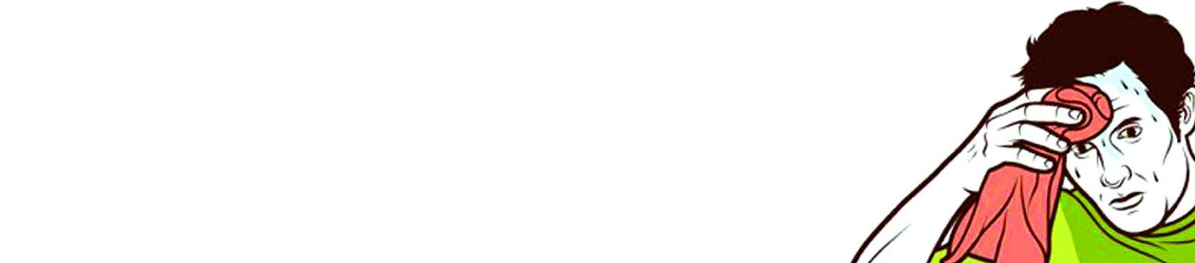